In [1]:
import tensorflow
import pandas as pd
import time
import numpy as np
import pylab as plt
import multiprocessing as mp
import statistics
from statistics import mean

import librosa
from librosa import feature
from glob import glob
import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D, Activation
from tensorflow.keras.callbacks import Callback
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
min_max_scaler = preprocessing.MinMaxScaler()

encoder = OneHotEncoder()

In [4]:
rootdir = '../audio-files'
audio_files = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        audio_files.append(os.path.join(subdir, file))
# audio_files = audio_files[1:]

In [5]:
len(audio_files)

1440

In [6]:
dict_actors = {}
for audio_file in audio_files:
    try :
        if (len(dict_actors[audio_file[-33:-25]])>0):
            dict_actors[audio_file[-33:-25]].append(audio_file)
    except:
        dict_actors[audio_file[-33:-25]] = []
        dict_actors[audio_file[-33:-25]].append(audio_file)

In [7]:
data = pd.DataFrame(columns = ['Actor','Modality','Vocal_channel','Emotion','Emotional_intensity','Statement','Repetion','Gender','Audio_file'])

In [8]:
def get_gender(value):
    if(int(value)%2==0):
        return 1
    else :
        return 0

for keys in dict_actors:
    for files in dict_actors[keys]:
        data.loc[len(data)] = [keys,int(files[-24:-22]),int(files[-21:-19]),int(files[-18:-16]),int(files[-15:-13]),int(files[-12:-10]),int(files[-9:-7]),get_gender(files[-6:-4]),files]

In [9]:
def get_feature_vector(y, sr):
    feature_vector = []
    
    # multi-dim features
    feature_vector.extend(np.mean(feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1))
    feature_vector.extend(np.mean(feature.chroma_stft(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(feature.spectral_contrast(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr),axis=1))
    feature_vector.extend(np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1))
    
    # single-dim features with special requirements
    feature_vector.append(np.mean(feature.rms(y=y)))
    feature_vector.append(np.mean(feature.zero_crossing_rate(y=y)))
    feature_vector.extend([np.mean(x) for x in librosa.piptrack(y=y, sr=sr)])
    
    # single-dim features
    feat_list = [
        librosa.onset.onset_strength,
        feature.spectral_rolloff,
        feature.melspectrogram,
        feature.spectral_centroid,
        feature.spectral_bandwidth
    ]
    
    for temp_func in feat_list:
        feature_vector.append(np.mean(temp_func(y=y, sr=sr)))
    
    return feature_vector

In [ ]:
audio_features = []
for i in range(data.shape[0]):
   y , sr = librosa.load(data.iloc[i]['Audio_file'],sr=None)
   feature_vector = get_feature_vector(y, sr)
   audio_features.append(feature_vector)

In [ ]:
data_features = data.copy()
data_features = data_features.drop("Audio_file",axis=1)
data_features['librosa'] = audio_features

In [ ]:
features = pd.DataFrame(data_features['librosa'].values.tolist())
labels = data['Emotion']
features_values = features.values

In [ ]:
features_scaled_values = min_max_scaler.fit_transform(features_values)
features_normalised = pd.DataFrame(features_scaled_values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_normalised, labels, test_size=0.30, random_state=42)

In [ ]:
X_train.to_csv('./SER_data/X_train.csv', index=False)
X_test.to_csv('./SER_data/X_test.csv', index=False)
y_train.to_csv('./SER_data/y_train.csv', index=False)
y_test.to_csv('./SER_data/y_test.csv', index=False)

In [10]:
X_train = pd.read_csv("./SER_data/X_train.csv")
X_test = pd.read_csv("./SER_data/X_test.csv")
y_train = pd.read_csv("./SER_data/y_train.csv")
y_test = pd.read_csv("./SER_data/y_test.csv")

In [11]:
X_train_cnn = np.expand_dims(X_train,axis=2)
X_test_cnn = np.expand_dims(X_test,axis=2)
y_train_cnn = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test_cnn = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [25]:
def cnn_layers(no_epochs, batch_size, X_train, y_train, X_test, y_test, checkpoint='models/ser_175'):  

    model = Sequential()

    model.add(Conv1D(256, 5, padding='same', input_shape=(X_train.shape[1],1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5,padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(4)))
    model.add(Dropout(0.1))

    # model.add(Conv1D(64, 5,padding='same'))
    # model.add(Activation('relu'))
    # # model.add(MaxPooling1D(pool_size=(2)))
    # model.add(Dropout(0.1))

    model.add(Flatten())
    # model.add(Dense(128))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    model.add(Dense(64))
    model.add(Dropout(0.2))
    model.add(Dense(8))
    model.add(Activation('softmax'))

    print(model.summary())

    # set callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                  factor=0.5, patience=4, 
                                                  verbose=1, mode='max', 
                                                  min_lr=0.001)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                verbose=1)

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, 
                                                        save_weights_only=False,
                                                        monitor='val_accuracy', 
                                                        mode='max', 
                                                        save_best_only=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=2,
                use_multiprocessing=False,
                callbacks = [model_checkpoint],
                validation_data=(X_test, y_test))

    # loading best weights
    model.load_weights(checkpoint)
    
    return history, model

In [26]:
batch_size = 16
history, best_model = cnn_layers(150, batch_size, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 175, 256)          1536      
                                                                 
 activation_9 (Activation)   (None, 175, 256)          0         
                                                                 
 batch_normalization_6 (Batc  (None, 175, 256)         1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 21, 256)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 21, 256)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 21, 128)          

c:\users\iyeng\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


INFO:tensorflow:Assets written to: models\ser_175\assets
63/63 - 5s - loss: 3.4858 - accuracy: 0.1567 - val_loss: 2.0984 - val_accuracy: 0.1713 - 5s/epoch - 82ms/step
Epoch 2/150
63/63 - 1s - loss: 2.8190 - accuracy: 0.1875 - val_loss: 2.1459 - val_accuracy: 0.1389 - 940ms/epoch - 15ms/step
Epoch 3/150
63/63 - 1s - loss: 2.6078 - accuracy: 0.2073 - val_loss: 2.1800 - val_accuracy: 0.1319 - 907ms/epoch - 14ms/step
Epoch 4/150
63/63 - 1s - loss: 2.3886 - accuracy: 0.2312 - val_loss: 2.1876 - val_accuracy: 0.1366 - 845ms/epoch - 13ms/step
Epoch 5/150
63/63 - 1s - loss: 2.2747 - accuracy: 0.2391 - val_loss: 2.1879 - val_accuracy: 0.1644 - 818ms/epoch - 13ms/step
Epoch 6/150
INFO:tensorflow:Assets written to: models\ser_175\assets
63/63 - 4s - loss: 2.2241 - accuracy: 0.2262 - val_loss: 2.0956 - val_accuracy: 0.1991 - 4s/epoch - 58ms/step
Epoch 7/150
INFO:tensorflow:Assets written to: models\ser_175\assets
63/63 - 4s - loss: 2.1260 - accuracy: 0.2589 - val_loss: 2.0182 - val_accuracy: 0.229

Epoch 58/150
63/63 - 1s - loss: 1.3747 - accuracy: 0.4762 - val_loss: 1.4296 - val_accuracy: 0.4630 - 1s/epoch - 17ms/step
Epoch 59/150
63/63 - 1s - loss: 1.3451 - accuracy: 0.4871 - val_loss: 1.4295 - val_accuracy: 0.4838 - 1s/epoch - 16ms/step
Epoch 60/150
63/63 - 1s - loss: 1.3427 - accuracy: 0.4831 - val_loss: 1.4571 - val_accuracy: 0.4560 - 839ms/epoch - 13ms/step
Epoch 61/150
63/63 - 1s - loss: 1.3156 - accuracy: 0.5129 - val_loss: 1.4610 - val_accuracy: 0.4583 - 838ms/epoch - 13ms/step
Epoch 62/150
63/63 - 1s - loss: 1.3294 - accuracy: 0.5099 - val_loss: 1.4333 - val_accuracy: 0.4722 - 830ms/epoch - 13ms/step
Epoch 63/150
63/63 - 1s - loss: 1.3195 - accuracy: 0.5069 - val_loss: 1.4592 - val_accuracy: 0.4769 - 828ms/epoch - 13ms/step
Epoch 64/150
63/63 - 1s - loss: 1.2740 - accuracy: 0.5298 - val_loss: 1.4759 - val_accuracy: 0.4514 - 829ms/epoch - 13ms/step
Epoch 65/150
63/63 - 1s - loss: 1.2747 - accuracy: 0.5099 - val_loss: 1.4297 - val_accuracy: 0.4722 - 831ms/epoch - 13ms/ste

Epoch 119/150
63/63 - 1s - loss: 0.8383 - accuracy: 0.6845 - val_loss: 1.3697 - val_accuracy: 0.5116 - 938ms/epoch - 15ms/step
Epoch 120/150
63/63 - 1s - loss: 0.8096 - accuracy: 0.7073 - val_loss: 1.3599 - val_accuracy: 0.5278 - 918ms/epoch - 15ms/step
Epoch 121/150
63/63 - 1s - loss: 0.7787 - accuracy: 0.7113 - val_loss: 1.3960 - val_accuracy: 0.5347 - 938ms/epoch - 15ms/step
Epoch 122/150
63/63 - 1s - loss: 0.8054 - accuracy: 0.6885 - val_loss: 1.3866 - val_accuracy: 0.5278 - 833ms/epoch - 13ms/step
Epoch 123/150
63/63 - 1s - loss: 0.8325 - accuracy: 0.6915 - val_loss: 1.3488 - val_accuracy: 0.5208 - 827ms/epoch - 13ms/step
Epoch 124/150
63/63 - 1s - loss: 0.7677 - accuracy: 0.7083 - val_loss: 1.4337 - val_accuracy: 0.5208 - 820ms/epoch - 13ms/step
Epoch 125/150
63/63 - 1s - loss: 0.7597 - accuracy: 0.7312 - val_loss: 1.3546 - val_accuracy: 0.5463 - 822ms/epoch - 13ms/step
Epoch 126/150
INFO:tensorflow:Assets written to: models\ser_175\assets
63/63 - 4s - loss: 0.7314 - accuracy: 0.

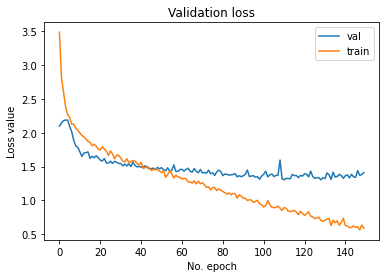

In [27]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Validation loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(['val', 'train'], loc='upper right')
plt.show()

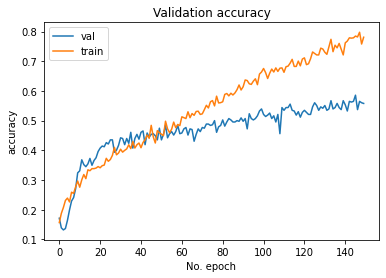

In [28]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(['val', 'train'], loc='upper left')
plt.show()

In [29]:
pred_test = best_model.predict(X_test_cnn)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test_cnn)

In [30]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

           1       0.28      0.42      0.33        19
           2       0.61      0.59      0.60        59
           3       0.66      0.56      0.60        72
           4       0.47      0.51      0.49        49
           5       0.66      0.72      0.69        57
           6       0.56      0.58      0.57        53
           7       0.46      0.57      0.51        46
           8       0.80      0.61      0.69        77

    accuracy                           0.59       432
   macro avg       0.56      0.57      0.56       432
weighted avg       0.61      0.59      0.59       432

